# Dataset

Let us fetch the revives dataset from this github gist

In [ ]:
!pip install -q numpy pandas seaborn pydantic

: 

In [ ]:
!curl https://gist.githubusercontent.com/blacksmithop/cc2800983e5b2fcbc4fcee177bfa1619/raw/16cc5743d5218ded8da01e79f607bc4cedaee86c/oxiblurr_revives.json > ./data/revives.json

: 

In [5]:
from json import load

In [6]:
with open("./revives.json") as f:
  revives = load(f)

In [7]:
len(revives)

193

In [8]:
revives[0]

{'id': 14940099,
 'reviver': {'id': 2877105,
  'name': 'Nixi',
  'faction': {'id': 40992, 'name': 'Medic!!'},
  'skill': 62.42},
 'target': {'id': 1712955,
  'name': 'oxiblurr',
  'faction': {'id': 41164, 'name': 'UNiTed Flying Doctors'},
  'hospital_reason': 'Mugged by someone',
  'early_discharge': False,
  'last_action': 1760693666,
  'online_status': 'Idle'},
 'success_chance': 96.24,
 'result': 'success',
 'timestamp': 1760693993}

# Defining a Schema

Having a pydantic schema will make it easier to access the various members

In [11]:
from pydantic import BaseModel
from typing import Optional

In [12]:
class FactionFull(BaseModel):
    id: Optional[int]
    name: Optional[str]

class ReviverFull(BaseModel):
    id: int
    name: Optional[str]
    faction: Optional[FactionFull]
    skill: Optional[float]

class TargetFull(BaseModel):
    id: int
    name: Optional[str]
    faction: Optional[FactionFull]
    hospital_reason: str
    early_discharge: bool
    last_action: int
    online_status: str

class ReviveFull(BaseModel):
    id: int
    reviver: ReviverFull
    target: TargetFull
    success_chance: float
    result: str
    timestamp: int

In [14]:
revive_data = [ReviveFull(**item) for item in revives]

In [16]:
from pprint import pprint

In [19]:
pprint(revive_data[0].model_dump())

{'id': 14940099,
 'result': 'success',
 'reviver': {'faction': {'id': 40992, 'name': 'Medic!!'},
             'id': 2877105,
             'name': 'Nixi',
             'skill': 62.42},
 'success_chance': 96.24,
 'target': {'early_discharge': False,
            'faction': {'id': 41164, 'name': 'UNiTed Flying Doctors'},
            'hospital_reason': 'Mugged by someone',
            'id': 1712955,
            'last_action': 1760693666,
            'name': 'oxiblurr',
            'online_status': 'Idle'},
 'timestamp': 1760693993}


# Filtering

Let us filter this dataset only include *your* revives

In [20]:
MY_USER_ID = 1712955

In [21]:
my_revive_data = [
    revive for revive in revive_data
    if revive.reviver.id == MY_USER_ID
]

In [22]:
len(revive_data), len(my_revive_data)

(193, 186)

In [23]:
pprint(my_revive_data[0].model_dump())

{'id': 14939572,
 'result': 'success',
 'reviver': {'faction': {'id': 41164, 'name': 'UNiTed Flying Doctors'},
             'id': 1712955,
             'name': 'oxiblurr',
             'skill': 30.9},
 'success_chance': 93.09,
 'target': {'early_discharge': False,
            'faction': {'id': 38887, 'name': 'Claws'},
            'hospital_reason': 'Gunshot wound to the chest with lung puncture',
            'id': 1771815,
            'last_action': 1760669022,
            'name': 'ManceR',
            'online_status': 'Offline'},
 'timestamp': 1760683513}


In [24]:
from json import dump

In [26]:
with open("my_revives.json", "w") as f:
  dump([item.model_dump() for item in my_revive_data], f, indent=4)

# Analysis

Let us plot and an analyze this data

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [28]:
skill_success_data = [ [revive.reviver.skill, revive.success_chance] for revive in
    my_revive_data]

skill_success_data[:5]
# also consider outcome

[[30.9, 93.09], [30.83, 87.56], [30.72, 83.45], [30.6, 93.06], [30.45, 88.59]]

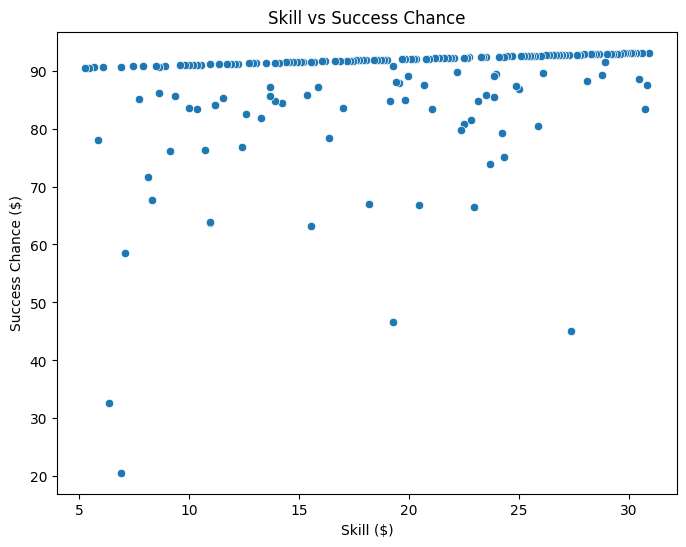

In [30]:
np.random.seed(42)
df = pd.DataFrame(skill_success_data, columns=['skill', 'success_chance'])

# Basic scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='skill', y='success_chance')
plt.title('Skill vs Success Chance')
plt.xlabel('Skill ($)')
plt.ylabel('Success Chance ($)')
plt.show()

In [31]:
df

,skill,success_chance
0,30.90,93.09
1,30.83,87.56
2,30.72,83.45
3,30.60,93.06
4,30.45,88.59
...,...,...
181,5.65,90.56
182,5.45,90.54
183,5.26,90.52
184,NaN,90.50


# Skill Progression

In [40]:
class DailySkillProgress(BaseModel):
    date: str
    start_skill: float
    end_skill: float
    daily_gain: float
    avg_skill: float
    expected_multiplier: float
    successful_revives: int
    total_revives: int
    success_rate: float

class SkillRangeTrend(BaseModel):
    skill_range: str
    avg_daily_gain: float
    avg_multiplier: float
    days_count: int

In [42]:
import json
from datetime import datetime, timedelta
from collections import defaultdict
import math
from typing import List

In [43]:
def calculate_daily_skill_gains(revive_data: List[ReviveFull]) -> List[DailySkillProgress]:
    """
    Calculate daily skill gains from revive data, accounting for diminishing returns.

    Args:
        revive_data: List of revive records

    Returns:
        List of daily summaries with skill gains and progression rates
    """

    def skill_gain_multiplier(current_skill: float) -> float:
        """Calculate diminishing returns multiplier based on skill level"""
        return max(0.01, 1 - 0.208 * math.log(current_skill))

    # Sort revives by timestamp
    sorted_revives = sorted(revive_data, key=lambda x: x.timestamp)

    # Group revives by date
    daily_revives = defaultdict(list)
    for revive in sorted_revives:
        if revive.reviver.skill is None:
            continue

        date = datetime.fromtimestamp(revive.timestamp).date()
        daily_revives[date].append(revive)

    # Calculate daily skill progression
    daily_progression = []

    for date in sorted(daily_revives.keys()):
        day_revives = daily_revives[date]

        # Get starting skill for the day (first revive of the day)
        day_start_skill = day_revives[0].reviver.skill

        # Get ending skill for the day (last revive of the day)
        day_end_skill = day_revives[-1].reviver.skill

        # Calculate net gain for the day
        daily_gain = day_end_skill - day_start_skill

        # Calculate expected multiplier for this skill range
        avg_skill = (day_start_skill + day_end_skill) / 2
        expected_multiplier = skill_gain_multiplier(avg_skill)

        # Count successful revives
        successful_revives = sum(1 for r in day_revives if r.result == 'success')
        total_revives = len(day_revives)

        daily_progression.append(DailySkillProgress(
            date=str(date),
            start_skill=day_start_skill,
            end_skill=day_end_skill,
            daily_gain=daily_gain,
            avg_skill=avg_skill,
            expected_multiplier=expected_multiplier,
            successful_revives=successful_revives,
            total_revives=total_revives,
            success_rate=successful_revives / total_revives if total_revives > 0 else 0
        ))

    return daily_progression

In [44]:
def analyze_skill_progression_trends(daily_progression: List[DailySkillProgress]) -> List[SkillRangeTrend]:
    """
    Analyze trends in skill progression over time
    """
    if not daily_progression:
        return []

    # Group by skill ranges to see progression slowdown
    skill_ranges = {
        '1-10': [],
        '10-20': [],
        '20-30': [],
        '30+': []
    }

    for day in daily_progression:
        avg_skill = day.avg_skill
        if avg_skill < 10:
            skill_ranges['1-10'].append(day)
        elif avg_skill < 20:
            skill_ranges['10-20'].append(day)
        elif avg_skill < 30:
            skill_ranges['20-30'].append(day)
        else:
            skill_ranges['30+'].append(day)

    # Calculate average daily gains by skill range
    trends = []
    for range_name, days in skill_ranges.items():
        if days:
            avg_gain = sum(day.daily_gain for day in days) / len(days)
            avg_multiplier = sum(day.expected_multiplier for day in days) / len(days)
            trends.append(SkillRangeTrend(
                skill_range=range_name,
                avg_daily_gain=avg_gain,
                avg_multiplier=avg_multiplier,
                days_count=len(days)
            ))

    return trends

In [45]:
def get_recent_progression_stats(daily_progression: List[DailySkillProgress], days: int = 30) -> dict:
    """
    Get progression statistics for the most recent period
    """
    if not daily_progression:
        return {}

    recent_days = daily_progression[-days:]

    total_gain = sum(day.daily_gain for day in recent_days)
    avg_daily_gain = total_gain / len(recent_days)
    avg_multiplier = sum(day.expected_multiplier for day in recent_days) / len(recent_days)
    total_revives = sum(day.total_revives for day in recent_days)
    success_rate = sum(day.successful_revives for day in recent_days) / total_revives if total_revives > 0 else 0

    return {
        'period_days': len(recent_days),
        'total_skill_gain': total_gain,
        'avg_daily_gain': avg_daily_gain,
        'avg_multiplier': avg_multiplier,
        'total_revives': total_revives,
        'success_rate': success_rate,
        'start_skill': recent_days[0].start_skill,
        'end_skill': recent_days[-1].end_skill
    }

In [46]:
# Example usage function
def analyze_revive_progression(revives: List[ReviveFull]) -> dict:
    """
    Main analysis function that returns comprehensive progression data
    """
    daily_progression = calculate_daily_skill_gains(revives)
    trends = analyze_skill_progression_trends(daily_progression)
    recent_stats = get_recent_progression_stats(daily_progression, days=30)

    return {
        'daily_progression': daily_progression,
        'skill_trends': trends,
        'recent_performance': recent_stats,
        'total_analysis_days': len(daily_progression)
    }

In [49]:
progression = analyze_revive_progression(my_revive_data)

In [50]:
progression

{'daily_progression': [DailySkillProgress(date='2025-08-24', start_skill=5.26, end_skill=5.26, daily_gain=0.0, avg_skill=5.26, expected_multiplier=0.6546927464360793, successful_revives=1, total_revives=1, success_rate=1.0),
  DailySkillProgress(date='2025-08-30', start_skill=5.45, end_skill=5.45, daily_gain=0.0, avg_skill=5.45, expected_multiplier=0.6473119533955682, successful_revives=1, total_revives=1, success_rate=1.0),
  DailySkillProgress(date='2025-09-08', start_skill=5.65, end_skill=5.65, daily_gain=0.0, avg_skill=5.65, expected_multiplier=0.6398156466070632, successful_revives=1, total_revives=1, success_rate=1.0),
  DailySkillProgress(date='2025-09-15', start_skill=5.83, end_skill=5.83, daily_gain=0.0, avg_skill=5.83, expected_multiplier=0.6332924639246206, successful_revives=1, total_revives=1, success_rate=1.0),
  DailySkillProgress(date='2025-09-21', start_skill=6.07, end_skill=6.07, daily_gain=0.0, avg_skill=6.07, expected_multiplier=0.6249014101451473, successful_revive